<a href="https://colab.research.google.com/github/UdayKumar9381/D-3F-306/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-14 09:24:27--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.77, 18.160.200.112, 18.160.200.71, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   204MB/s    in 0.2s    

2024-05-14 09:24:27 (204 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


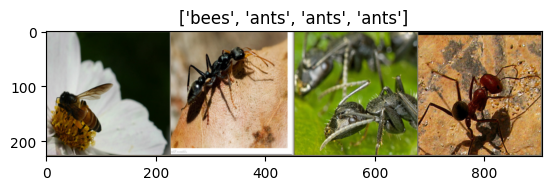

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.8MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.4820 Acc: 0.8033

Epoch 1/4
----------
Loss: 0.5262 Acc: 0.7787

Epoch 2/4
----------
Loss: 0.4981 Acc: 0.7992

Epoch 3/4
----------
Loss: 0.3142 Acc: 0.8811

Epoch 4/4
----------
Loss: 0.4067 Acc: 0.8566



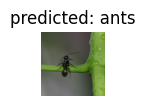

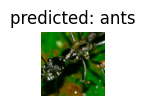

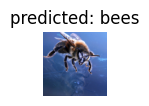

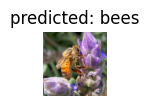

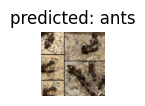

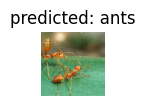

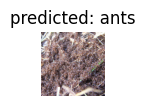

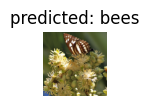

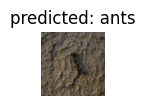

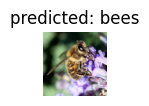

In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


# **QUESTION-1 ANSWER**

Data augmentations such as resizing, cropping, and other transformations play a crucial role in training machine learning models, particularly in computer vision tasks. Here's why they are significant:

1. **Increased Data Diversity**: Augmentations expand the dataset by creating variations of existing images. This diversity exposes the model to a wider range of scenarios, viewpoints, and conditions, which can enhance its ability to generalize to unseen data.

2. **Regularization**: Augmentations act as a form of regularization, mitigating overfitting by introducing noise and variability during training. This prevents the model from memorizing specific examples and encourages it to learn more robust and generalizable features.

3. **Translation Invariance**: Techniques like random cropping and flipping help the model learn features that are invariant to translations and orientations. This is particularly important in tasks where object location and orientation vary, as the model needs to recognize objects regardless of their position in the image.

4. **Improved Robustness**: Augmentations simulate real-world conditions and variations, making the model more robust to changes in lighting, scale, rotation, and other factors. This can result in better performance when deploying the model in practical settings where such variations are common.

5. **Data Efficiency**: By generating augmented samples on-the-fly during training, augmentations allow us to make better use of limited training data. This is especially beneficial in scenarios where collecting large labeled datasets is challenging or expensive.

6. **Enhanced Learning**: Augmenting the training data with transformations helps the model learn more meaningful and invariant representations of the underlying data distribution. This can lead to faster convergence and improved learning effectiveness.

Overall, data augmentations are a critical component of training deep learning models, contributing to better generalization, robustness, and performance on various computer vision tasks. They allow models to learn from diverse and representative data, leading to more reliable and practical solutions.


# **QUESTION-2 ANSWER**

If you don't use a pretrained ResNet model and instead train it from scratch on the ants vs. bees dataset, the performance may not be as good as when using transfer learning with a pretrained model. Here's what you might observe:

1. **Lower Accuracy**: Training a deep neural network from scratch on a relatively small dataset like the ants vs. bees dataset could lead to lower accuracy compared to using transfer learning. Without the pretrained weights, the model starts with random initialization, which might not capture meaningful representations from the data efficiently.

2. **Higher Risk of Overfitting**: Without the regularization effect of pretrained weights, there's a higher risk of overfitting to the training data, especially given the limited size of the dataset. The model may memorize the training examples instead of learning generalizable features, leading to poor performance on unseen data.

3. **Slower Convergence**: Training from scratch might require more epochs for the model to converge to a satisfactory solution. Since the model needs to learn both low-level features and high-level representations from the data, the training process could be slower compared to fine-tuning a pretrained model.

4. **Increased Computational Resources**: Training a deep neural network from scratch requires significant computational resources, including time and hardware. Without the head start provided by pretrained weights, the model needs to learn everything from scratch, which can be computationally intensive.

In summary, while it's possible to train a ResNet model from scratch on the ants vs. bees dataset, doing so may result in lower performance and require more resources compared to using transfer learning with a pretrained model.

# **QUESTION-3 ANSWER**
The performance of a pretrained ResNet model on a dataset significantly different from the ants vs. bees data would depend on several factors:

1. **Domain Similarity**: If the pretraining dataset is from a domain that shares similar characteristics with the ants vs. bees data (e.g., natural images with similar objects and backgrounds), then the pretrained model may still capture useful and transferable features. In this case, using the pretrained model could lead to good performance.

2. **Task Relevance**: The extent to which the features learned during pretraining are relevant to the target task (ants vs. bees classification) also influences performance. If the pretraining task is closely related to the target task, the pretrained features are more likely to be beneficial. For example, if the pretraining task involved image classification or object recognition, the pretrained model might generalize well to the ants vs. bees classification task.

3. **Amount of Transfer Learning**: Transfer learning techniques such as fine-tuning and feature extraction can further adapt the pretrained model to the target task. Fine-tuning involves updating the weights of the pretrained model during training on the target dataset, while feature extraction involves using the pretrained model as a fixed feature extractor. The choice of transfer learning strategy can impact performance.

4. **Domain Shift**: If there is a significant domain shift between the pretraining dataset and the target dataset (e.g., pretraining on natural images but applying to medical images), the effectiveness of transfer learning may be reduced. In such cases, the pretrained features might not generalize well to the target domain, leading to suboptimal performance.

In conclusion, while using a pretrained ResNet model on a dataset different from the pretraining data can still yield good performance under certain conditions, factors such as domain similarity, task relevance, transfer learning strategy, and domain shift need to be carefully considered to assess the potential effectiveness of transfer learning.